In [37]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

font = {'family': 'normal',
        'weight': 'bold',
        'size': 22}
matplotlib.rc('font', **font)


In [38]:
L = 10 * 1e-3
c1 = .022 * 1e-6
c2 = .033 * 1e-6
c3 = .047 * 1e-6
c4 = .47 * 1e-6


def decrement(n, Ui, Uin):
    return (1 / n) * np.log(Ui / Uin)


Rm = np.concatenate([np.arange(0, 100, 10), np.arange(100, 500, 100)])
T = np.array([90, 100, 98, 99, 100, 100, 99, 98,
             97, 100, 98, 97, 99, 100]) * 1e-6
Ui = np.array([6.4, 6, 5.9, 5.7, 5.5, 5.3, 5.1,
              5.0, 4.8, 4.6, 4.4, 3.2, 2.3, 1.6])
Uin = np.array([2.4, 2, 1.7, 1.4, 1.3, 1.0, .8, .6, .7, .5, .3, .3, .2, .1])
n = np.array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1])
df = pd.DataFrame(data=np.array([Rm, T, Ui, Uin, n]).T, columns=[
                  'Rm', 'T', 'Ui', 'Uin', 'n'])
df['decrement'] = decrement(df.n, df.Ui, df.Uin)

C = np.array([c1, c2, c3, c4])
T_exp = np.array([99, 118, 140, 420]) * 1e-6

cdf = pd.DataFrame(data=np.array([C, T_exp]).T, columns=['C', 'T_exp'])


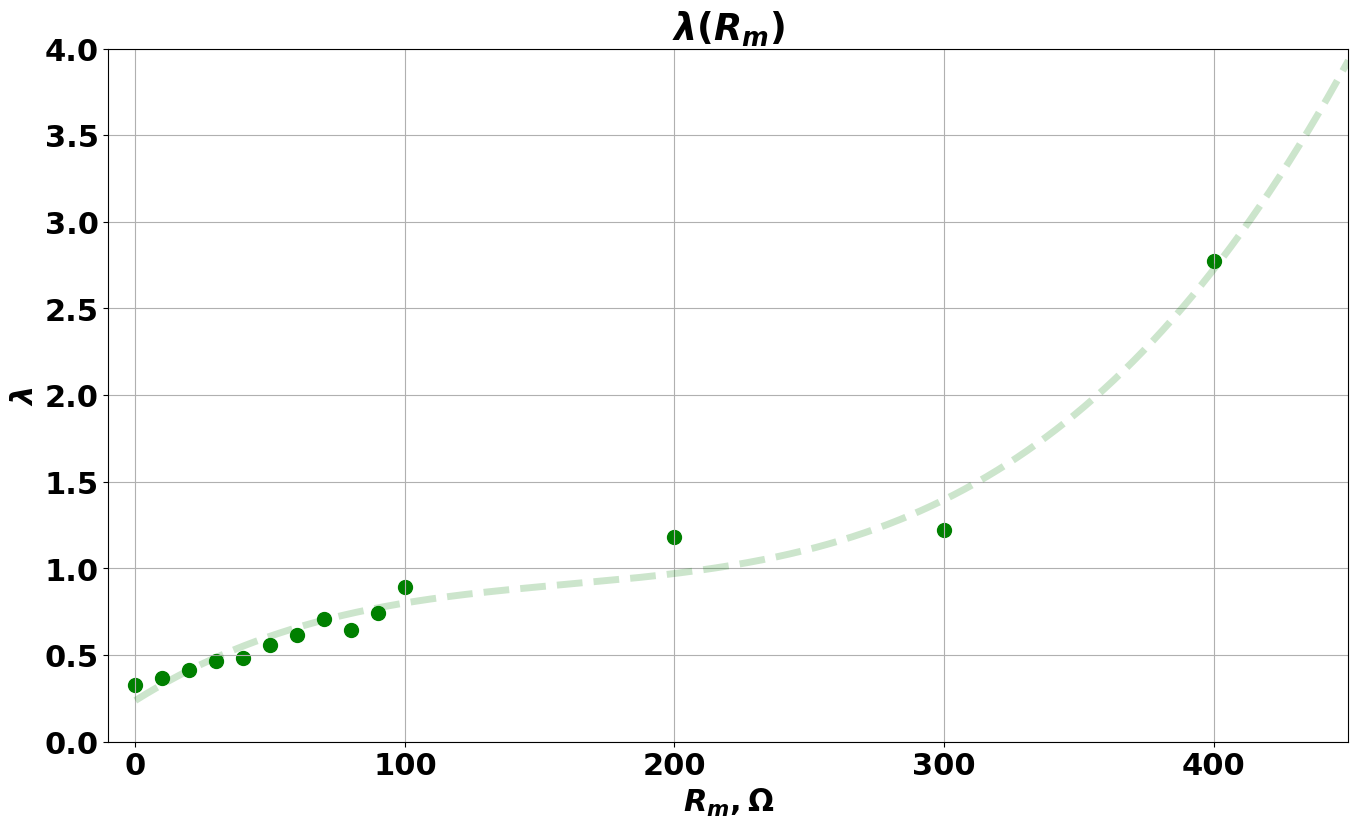

In [39]:
plt.figure(figsize=(16, 9))
x = np.linspace(0, 450, 1000)
p = np.polynomial.polynomial.Polynomial.fit(df.Rm, df.decrement, deg=3)
plt.plot(x, p(x), c='g', alpha=.2, linewidth=5, linestyle='--',)
plt.scatter(df.Rm, df.decrement, c='g', s=100)
plt.ylabel(r'$\lambda$')
plt.xlabel(r'$R_m, \Omega$')
plt.xlim(-10, 450)
plt.ylim(0, 4)
plt.grid()
plt.title(r'$\lambda(R_m)$')
plt.savefig('plots/lambda(Rm)')
plt.show()


In [40]:
from scipy.stats import linregress
lr = linregress(df.Rm[:11], df.decrement[:11])
slope = lr.slope
intercept = lr.intercept
R0 = 0
for val in np.linspace(-65, -55, 10000):
    if np.abs(slope * val + intercept) <= .00001:
        R0 = -val
        break
R0

60.355535553555356

In [41]:
df['R'] = df.Rm + R0
df['L'] = (((np.pi * df.R) ** 2) * c1) / (df.decrement ** 2)
Lmean = df.L[:11].mean()

df['T_evaluated'] = (2 * np.pi) / np.sqrt((1 / (df.L * c1)
                                           ) - ((df.R ** 2) / (4 * (df.L ** 2))))


In [42]:
df.L[:11].mean()

0.008330301319579243

In [43]:
df.L[:11].mean()

0.008330301319579243

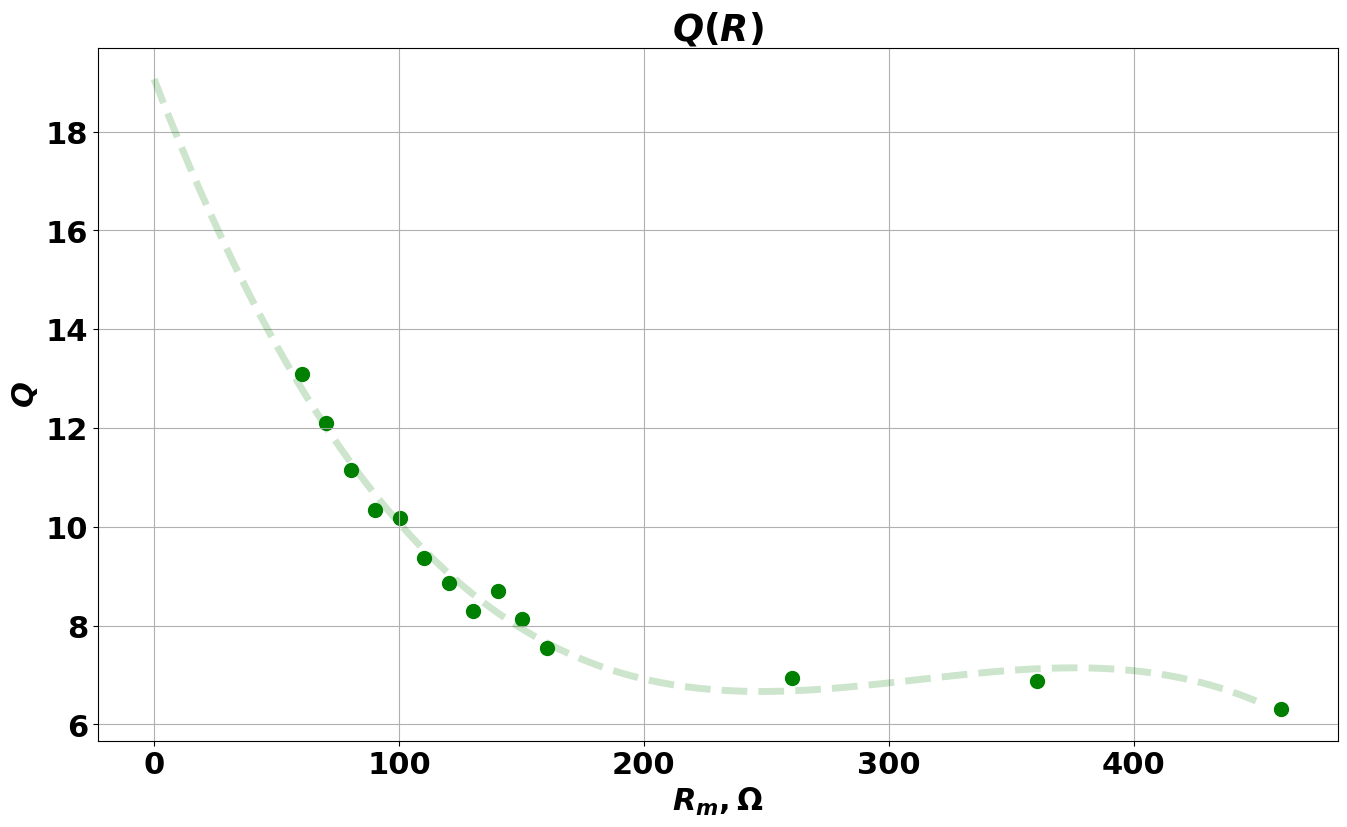

In [44]:
df['Q'] = (2 * np.pi) / (1 - np.exp(-2 * df.decrement))
plt.figure(figsize=(16, 9))
x = np.linspace(0, 450, 1000)
p = np.polynomial.polynomial.Polynomial.fit(df.R, df.Q, deg=3)
plt.plot(x, p(x), c='g', alpha=.2, linewidth=5, linestyle='--',)
plt.scatter(df.R, df.Q, c='g', s=100)
plt.ylabel(r'$Q$')
plt.xlabel(r'$R_m, \Omega$')
plt.grid()
plt.title(r'$Q(R)$')
plt.savefig('plots/Q(R).png')
plt.show()


In [45]:
cdf['T_theor'] = (2 * np.pi) / (np.sqrt((1 / (Lmean * cdf.C)) - ((R0 / (2 * Lmean)) ** 2)))
cdf['deltaT'] = (cdf.T_exp - cdf.T_theor) / (cdf.T_theor)

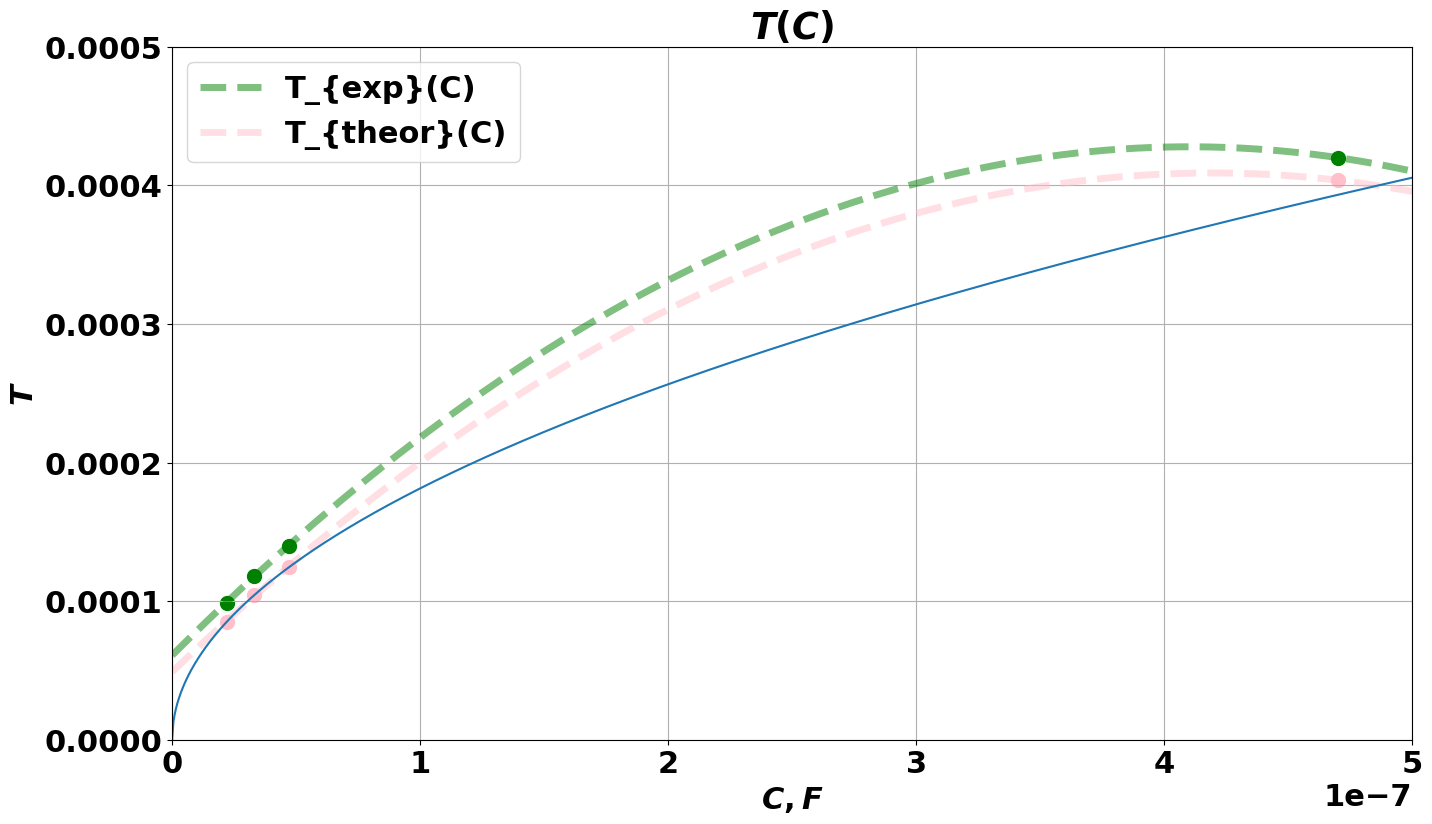

In [46]:
plt.figure(figsize=(16, 9))
x = np.linspace(0, 5 * 1e-7, 1000)
cdf.T_exp 
cdf.T_theor 
p_exp = np.polynomial.polynomial.Polynomial.fit(cdf.C, cdf.T_exp, deg=2)
p_theor = np.polynomial.polynomial.Polynomial.fit(cdf.C, cdf.T_theor, deg=2)
plt.plot(x, p_exp(x), c='g', alpha=.5, linewidth=5, linestyle='--', label=r'T_{exp}(C)')
plt.plot(x, p_theor(x), c='pink', alpha=.5, linewidth=5, linestyle='--', label=r'T_{theor}(C)')
plt.plot(x, 2 * np.pi * np.sqrt(Lmean * x))
plt.xlim(0, 5 * 1e-7)
plt.ylim(0, 5 * 1e-4)
plt.scatter(cdf.C, cdf.T_exp, c='g', s=100)
plt.scatter(cdf.C, cdf.T_theor, c='pink', s=100)
plt.ylabel(r'$T$')
plt.xlabel(r'$C, F$')
plt.grid()
plt.title(r'$T(C)$')
plt.legend()
plt.savefig('plots/T(C)')
plt.show()
